In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import skopt
from skopt import plots
sns.set(color_codes=True, font_scale=1.2)

sys.path.append('../../src')
import raybay

In [3]:
# Load treatment plan results
approved = np.load('approved/res.pkl', allow_pickle=True)
default = np.load('default/res.pkl', allow_pickle=True)
res_dummy = np.load('dummy/res_linear_quadratic_dummy_minimize.pkl', allow_pickle=True)
#res_bayes = np.load('bayes/res_linear_quadratic_gp_minimize.pkl', allow_pickle=True)

In [4]:
res_dummy.goal_df

,Roi,Type,GoalCriteria,AcceptanceLevel,ParameterValue
0,ChestWall,MaxDvh,AtMost,3000,3.42
1,D2cm,MaxDose,AtMost,2600,NaN
2,Esophagus,MaxDvh,AtMost,1880,30.71
3,Lung_Total-GTV,MaxDvh,AtMost,1160,58.59
4,Lung_Total-GTV,MaxDvh,AtMost,1240,39.06
5,PTV,MinDvh,AtLeast,4800,95.00
6,PTV,MaxDose,AtMost,8000,NaN
7,Ribs,MaxDvh,AtMost,3200,3.11
8,Ribs,MaxDose,AtMost,4000,NaN
9,SpinalCanal,MaxDvh,AtMost,1360,2.87


In [5]:
res_dummy.func_df

,Roi,FunctionType,DoseLevel,PercentVolume,EudParameterA,Weight
0,ChestWall,MaxDvh,3000,3.42,NaN,1
1,D2cm,MaxDose,"[0,2600]",0.00,NaN,1
2,Esophagus,MaxDvh,1880,30.71,NaN,1
3,Lung_Total-GTV,MaxDvh,1160,58.59,NaN,1
4,Lung_Total-GTV,MaxDvh,1240,39.06,NaN,1
5,PTV,MinDvh,4800,95.00,NaN,1
6,PTV,MaxDose,8000,0.00,NaN,1
7,Ribs,MaxDvh,3200,3.11,NaN,1
8,Ribs,MaxDose,"[0,4000]",0.00,NaN,1
9,SpinalCanal,MaxDvh,1360,2.87,NaN,1


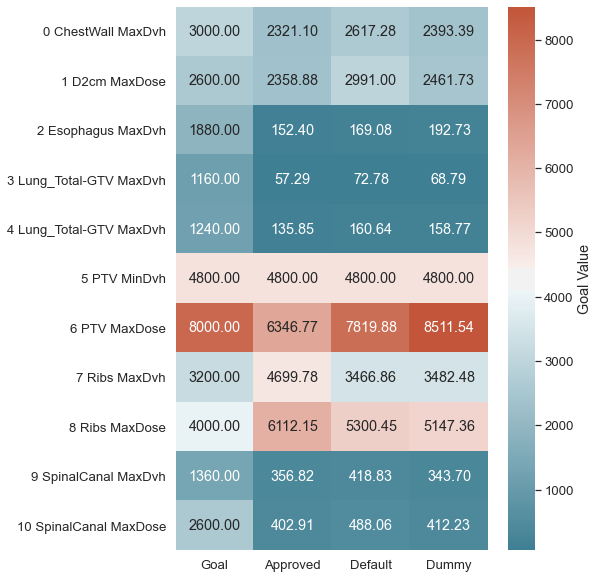

In [7]:
# Compare goal values
idx_dummy = np.argmin(res_dummy.opt_result.func_vals)
#idx_bayes = np.argmin(res_bayes.opt_result.func_vals)
X = np.zeros((len(approved.goal_df), 4)) # 5
roi_dict = {
    f"{index} {row['Roi']} {row['Type']}": index for index, row in approved.goal_df.iterrows()
}
for index, row in approved.goal_df.iterrows():
    X[index, 0] = row['AcceptanceLevel']
    X[index, 1] = approved.goal_dict[index][0]
    X[index, 2] = default.goal_dict[index][0]
    X[index, 3] = res_dummy.goal_dict[index][idx_dummy]
    #X[index, 4] = res_bayes.goal_dict[index][idx_bayes]
Y = pd.DataFrame(columns=['Goal', 'Approved', 'Default', 'Dummy'], data=X, index=roi_dict)
f, ax = plt.subplots(1, figsize=(7, 10))
sns.heatmap(Y, annot=True, cmap=sns.diverging_palette(220, 20, n=256), ax=ax, cbar_kws={'label': 'Goal Value'},
            fmt=".2f");

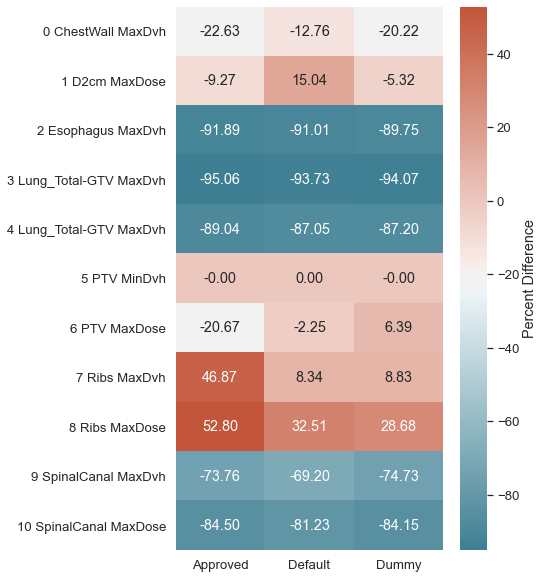

In [8]:
# Compare goal percent difference
X = np.zeros((len(approved.goal_df), 3)) # 4
for index, row in approved.goal_df.iterrows():
    X[index, 0] = -raybay.get_term(approved.goal_dict[index][0], row['AcceptanceLevel'], 'Max', 'linear')
    X[index, 1] = -raybay.get_term(default.goal_dict[index][0], row['AcceptanceLevel'], 'Max', 'linear')
    X[index, 2] = -raybay.get_term(res_dummy.goal_dict[index][idx_dummy], row['AcceptanceLevel'], 'Max', 'linear')
    #X[index, 3] = -raybay.get_term(res_bayes.goal_dict[index][idx_bayes], row['AcceptanceLevel'], 'Max', 'linear')
Y = pd.DataFrame(columns=['Approved', 'Default', 'Dummy'], data=X, index=roi_dict)
f, ax = plt.subplots(1, figsize=(6, 10))
sns.heatmap(Y, annot=True, cmap=sns.diverging_palette(220, 20, n=256), ax=ax, cbar_kws={'label': 'Percent Difference'},
            fmt='.2f');

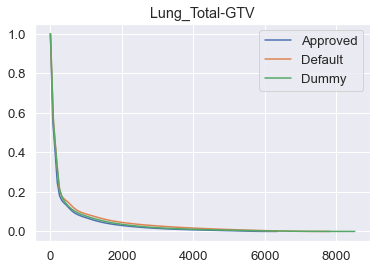

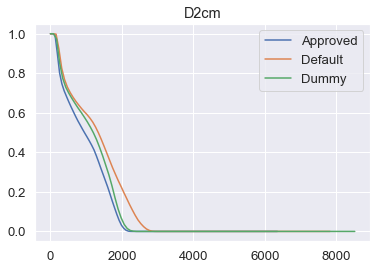

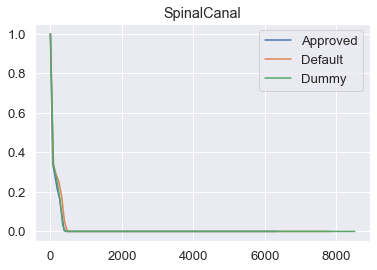

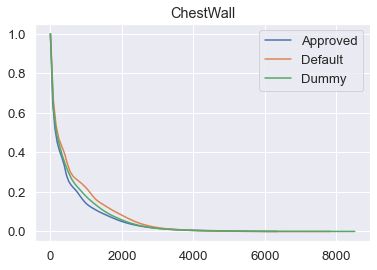

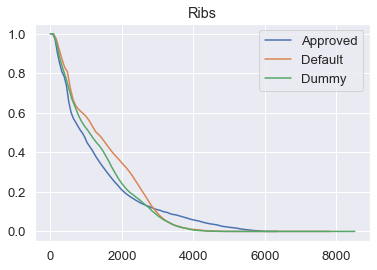

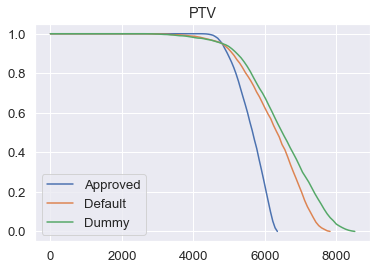

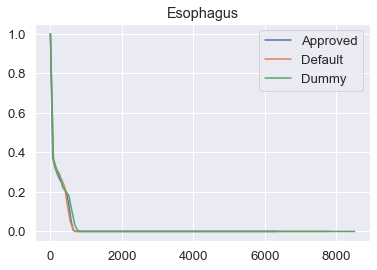

In [10]:
for roi in approved.roi_list:
    plt.figure()
    plt.plot(approved.dvh_dict['Dose'], approved.dvh_dict[roi])
    plt.plot(default.dvh_dict['Dose'], default.dvh_dict[roi])
    plt.plot(res_dummy.dvh_dict['Dose'], res_dummy.dvh_dict[roi])
    #plt.plot(res_bayes.dvh_dict['Dose'], res_bayes.dvh_dict[roi])
    plt.title(roi)
    plt.legend(['Approved', 'Default', 'Dummy'])

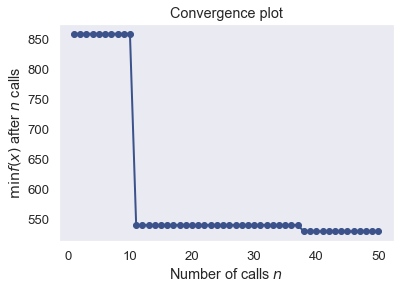

In [11]:
# Convergence of dummy
plots.plot_convergence(res_dummy.opt_result)